# Analiza ogłoszeń sprzedaży mieszkań ze strony otodom.pl

Łódź; 4300 ogłoszeń z dnia 29.01.2021

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [8]:
df_raw = pd.read_csv('otodom_lodz_mieszkania_sprzedaz.csv')

In [9]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 120)
df = df_raw[sorted(df_raw.columns[:])]
del df['Unnamed: 0']
display(df.head())

,ID,Unnamed: 0.1,characteristic_build_year,characteristic_building_floors_num,characteristic_building_material,characteristic_building_ownership,characteristic_building_type,characteristic_construction_status,characteristic_floor_no,characteristic_free_from,characteristic_heating,characteristic_m,characteristic_market,characteristic_price,characteristic_price_currency,characteristic_price_per_m,characteristic_remote_services,characteristic_rent,characteristic_rooms_num,characteristic_windows_type,feature_balkon,feature_domofon / wideofon,feature_drzwi / okna antywłamaniowe,feature_dwupoziomowe,feature_garaż/miejsce parkingowe,feature_internet,feature_klimatyzacja,feature_kuchenka,feature_lodówka,feature_meble,feature_monitoring / ochrona,feature_oddzielna kuchnia,feature_ogródek,feature_piekarnik,feature_piwnica,feature_pom. użytkowe,feature_pralka,feature_rolety antywłamaniowe,feature_system alarmowy,feature_taras,feature_telefon,feature_telewizja kablowa,feature_telewizor,feature_teren zamknięty,feature_winda,feature_zmywarka,geo_lat,geo_long,offer_dateCreated,offer_dateModified,offer_description,offer_location,offer_title,offer_url,owner_type
0,61449622,0,2002.0,3.0,concrete_plate,full_ownership,block,ready_to_use,floor_2,2021-01-29,urban,78.00,secondary,570000.0,PLN,7308.0,NaN,700.0,3,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,51.825560,19.434290,2021-01-29 16:42:56,2021-01-29 16:43:09,"<em>Kupujący nie płaci prowizji!</em><br><br>Przestrzenne 3 pokojowe mieszkanie na zamkniętym osiedlu, ciche i bezpi...","Łódź, Bałuty, Radogoszcz","Duże widne mieszkanie, Łódź Radogoszcz",https://www.otodom.pl/pl/oferta/duze-widne-mieszkanie-lodz-radogoszcz-ID49PQV.html#b7adc7f14c,agency
1,61449584,1,NaN,3.0,brick,NaN,tenement,to_renovation,floor_3,2021-03-01,electrical,33.00,secondary,15000.0,PLN,455.0,NaN,NaN,1,plastic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.766780,19.439500,2021-01-29 16:34:33,2021-01-29 16:39:10,Mieszkanie niewłasnościowe z umową najmu na czas nieoznaczony i z zameldowaniem. \r\nPowierzchnia 33m2. Składa się z...,"Łódź, Polesie, Stare Polesie",1 pokój w prywatnej kamienicy,https://www.otodom.pl/pl/oferta/1-pokoj-w-prywatnej-kamienicy-ID49PQk.html#b7adc7f14c,agency
2,61449583,2,NaN,NaN,brick,full_ownership,block,ready_to_use,ground_floor,NaN,urban,36.64,secondary,239000.0,PLN,6523.0,1.0,313.0,2,plastic,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,51.457980,19.368000,2021-01-29 16:34:00,2021-01-29 16:34:26,Zapraszam na pokaz mieszkań +48 575 431 633\r\n\r\nDo sprzedania wyremontowane mieszkanie dwupokojowe. \r\n\r\n\r\nO...,"Łódź, Bałuty, Teofilów",Świetna lokalizacja! Teofilów! Do zamieszkania!!,https://www.otodom.pl/pl/oferta/swietna-lokalizacja-teofilow-do-zamieszkania-ID49PQj.html#b7adc7f14c,agency
3,61449370,3,2021.0,6.0,brick,full_ownership,apartment,NaN,floor_1,NaN,urban,40.36,primary,268140.0,PLN,6644.0,NaN,NaN,2,plastic,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,51.746512,19.450905,2021-01-29 16:04:53,2021-01-29 16:05:24,OFERTA OD DEWELOPERA\r\nZERO % PROWIZJI\r\nBRAK PCC\r\n\r\nRABAT AŻ - 27.000 PLN\r\n\r\nOD PONIEDZIAŁKU WZROST CEN ...,"Łódź, Śródmieście, okolice al. Politechniki",2 pokoje przy Politechnice TYLKO DO KOŃCA TYGODNIA,https://www.otodom.pl/pl/oferta/2-pokoje-przy-politechnice-tylko-do-konca-tygodnia-ID49PMS.html#b7adc7f14c,agency
4,59502092,4,2020.0,4.0,NaN,NaN,block,NaN,NaN,NaN,NaN,69.45,primary,388920.0,PLN,5600.0,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.749814,19.507460,2019-07-23 11:58:13,2021-01-29 16:02:20,"Zielona oaza\r\nOliwkowe to miejsce niezwykłe. Otoczone świeżą, soczystą zielenią. Emanujące nowoczesnością....","Łódź, Widzew, Zarzew, ul. Stanisława Pr

In [10]:
for col in df.columns[1:]:
    if pd.api.types.is_string_dtype(df[col]):
        df[col].replace(np.NaN, "", inplace=True)

    if pd.api.types.is_numeric_dtype(df[col]):
        df[col].replace(np.NaN, 0, inplace=True)
        if not col.startswith('geo_') and not (col == 'characteristic_m'):
            df[col] = df[col].astype(int)

In [11]:
for x in df.index:
    if df.loc[x, "characteristic_rooms_num"] == 'more':
        df.drop(x, inplace = True)
df["characteristic_rooms_num"] = df["characteristic_rooms_num"].astype(int)

In [12]:
#https://www.google.com/maps/d/embed?mid=1JSrhdHx4LcvdLDDV-oJLiSg_iU4&ll=51.77311513928322%2C19.480402500000007&z=12
disctricts_map = gpd.read_file("lodz_dzielnice.geojson")
display(disctricts_map['geometry'].total_bounds)

array([19.320862, 51.686144, 19.639943, 51.859919])

In [13]:
df_geo = pd.DataFrame()
df_geo['geo_long'] = df[(df["geo_long"]>=19.320862) & (df["geo_long"]<=19.639943)]["geo_long"]
df_geo['geo_lat'] = df[(df["geo_lat"]>=51.686144) & (df["geo_lat"]<=51.859919)]["geo_lat"]
df_geo['characteristic_market'] = df['characteristic_market']
df_geo.dropna(inplace = True)
df_geo['geo_coordinates'] = df_geo[['geo_long' , 'geo_lat']].values.tolist()
# display(df['characteristic_market'].value_counts().sort_values())
df_geo['geo_coordinates'] = df_geo['geo_coordinates'].apply(Point)
df_geo = gpd.GeoDataFrame(df_geo, geometry='geo_coordinates')
df_geo = df_geo.set_crs(epsg=4326)
display(df_geo.head())

,geo_long,geo_lat,characteristic_market,geo_coordinates
0,19.434290,51.825560,secondary,POINT (19.43429 51.82556)
1,19.439500,51.766780,secondary,POINT (19.43950 51.76678)
3,19.450905,51.746512,primary,POINT (19.45091 51.74651)
4,19.507460,51.749814,primary,POINT (19.50746 51.74981)
5,19.450905,51.746618,primary,POINT (19.45091 51.74662)


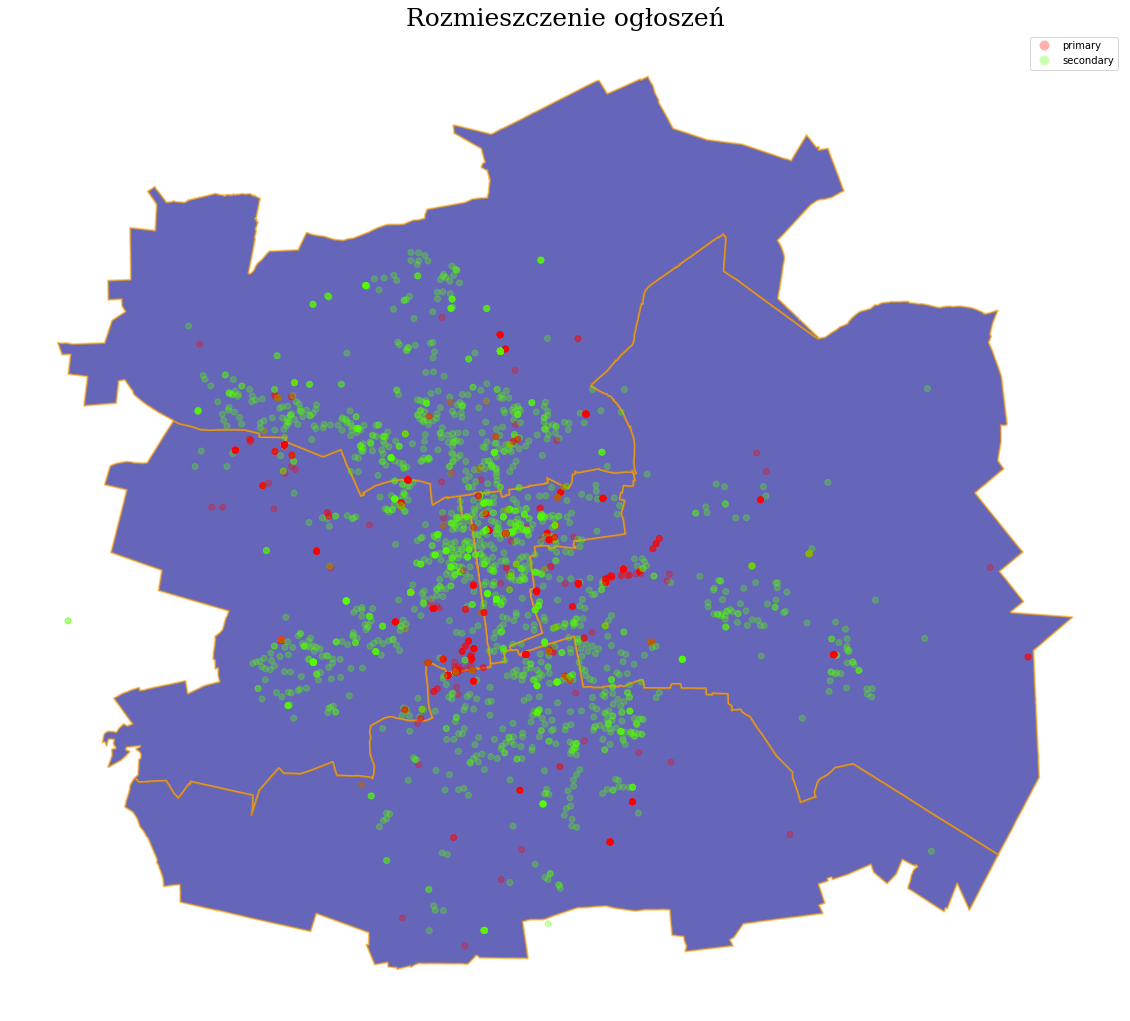

In [14]:
fig, ax = plt.subplots(1, figsize=(20,20))
base = disctricts_map.plot(ax=ax, color='Darkblue', edgecolor="orange", linewidth=2, alpha=0.6)
df_geo.plot(ax=base, column="characteristic_market",  cmap='prism', label='characteristic_market', 
            alpha=0.3, legend=True, categorical=True)
ax.get_legend()
font1 = {'family':'serif','color':'black','size':25}
font2 = {'family':'serif','color':'darkred','size':15}
plt.title('Rozmieszczenie ogłoszeń', fontdict = font1)
ax.axis('off')
plt.show()

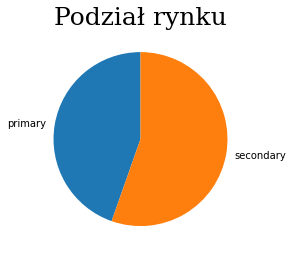

In [15]:
df.groupby("characteristic_market").size().plot(kind='pie', startangle = 90)
plt.title('Podział rynku', fontdict = font1)
plt.ylabel("")
plt.show()

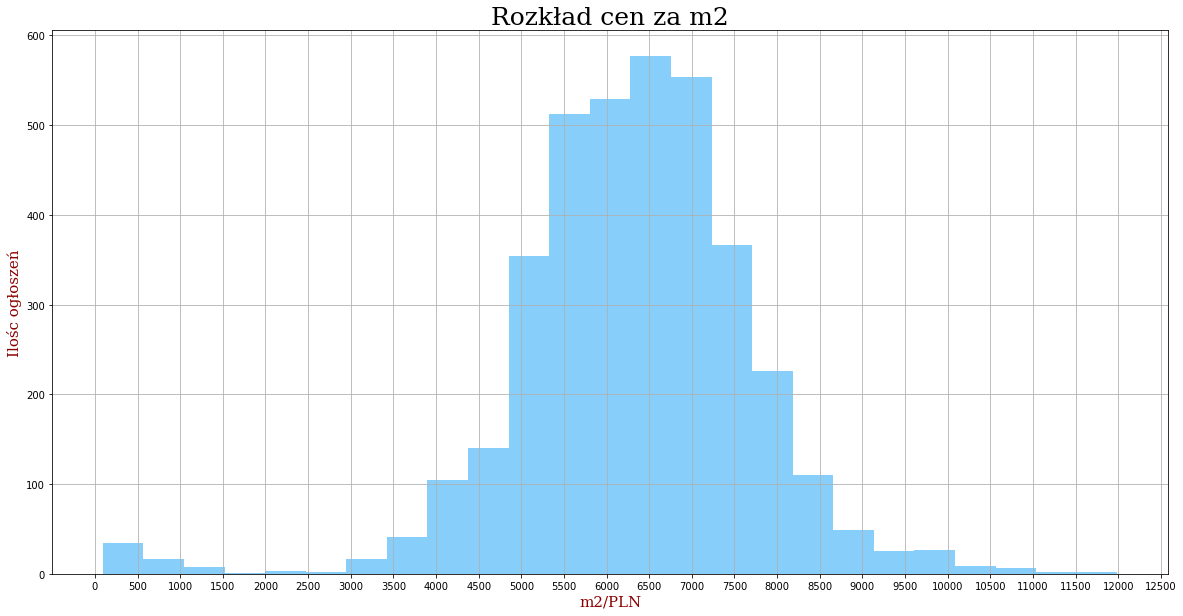

In [16]:
fig, ax = plt.subplots()
df.loc[df["characteristic_price_per_m"]>0]["characteristic_price_per_m"].plot(kind='hist', bins=25, grid=True, color='lightskyblue', figsize=(20,10))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 500))
plt.title('Rozkład cen za m2', fontdict=font1)
plt.xlabel('m2/PLN', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

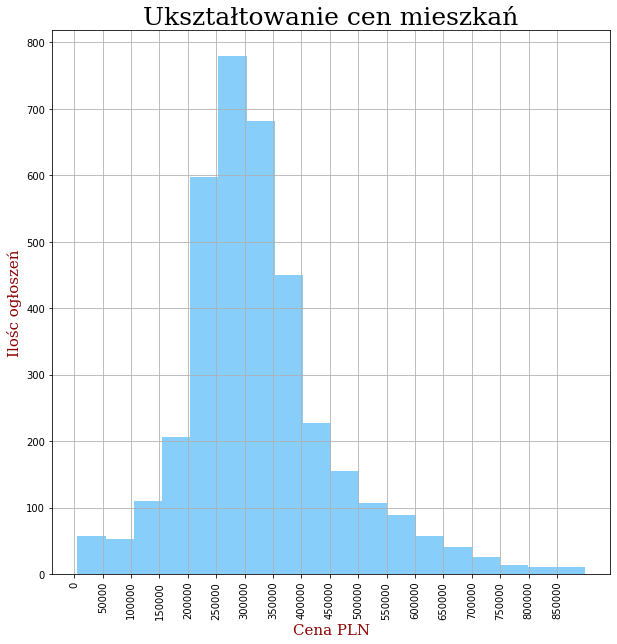

In [30]:
max_range = df["characteristic_price"].quantile(0.99)
fig, ax = plt.subplots()
df[(df["characteristic_price"]>0) & (df["characteristic_price"]<=max_range)]["characteristic_price"]\
    .hist(bins=18, color='lightskyblue', figsize=(10,10), xrot=90)
ax.xaxis.set_ticks(np.arange(0, max_range, 50000))
plt.title('Ukształtowanie cen mieszkań', fontdict=font1)
plt.xlabel('Cena PLN', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

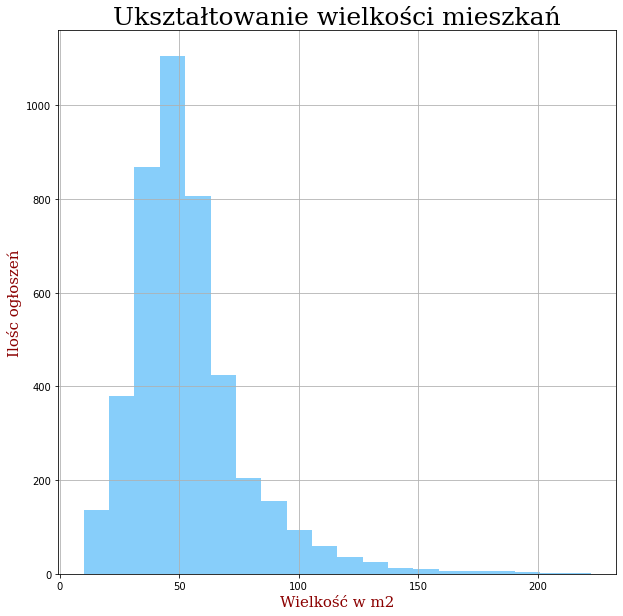

In [18]:
df["characteristic_m"].hist(bins=20, color='lightskyblue', figsize=(10,10))
plt.title('Ukształtowanie wielkości mieszkań', fontdict=font1)
plt.xlabel('Wielkość w m2', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

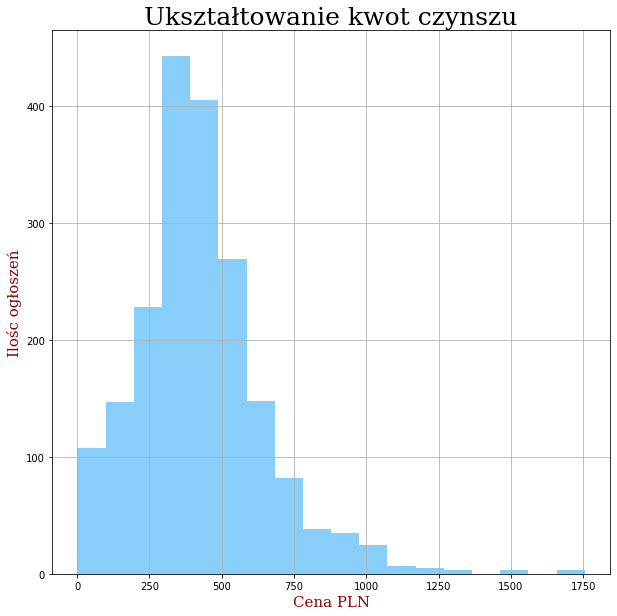

In [19]:
max_range = df["characteristic_rent"].quantile(0.999)
df[(df["characteristic_rent"]>0) & (df["characteristic_rent"]<=max_range)]["characteristic_rent"]\
    .hist(bins=18, color='lightskyblue', figsize=(10,10))
plt.title('Ukształtowanie kwot czynszu', fontdict=font1)
plt.xlabel('Cena PLN', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

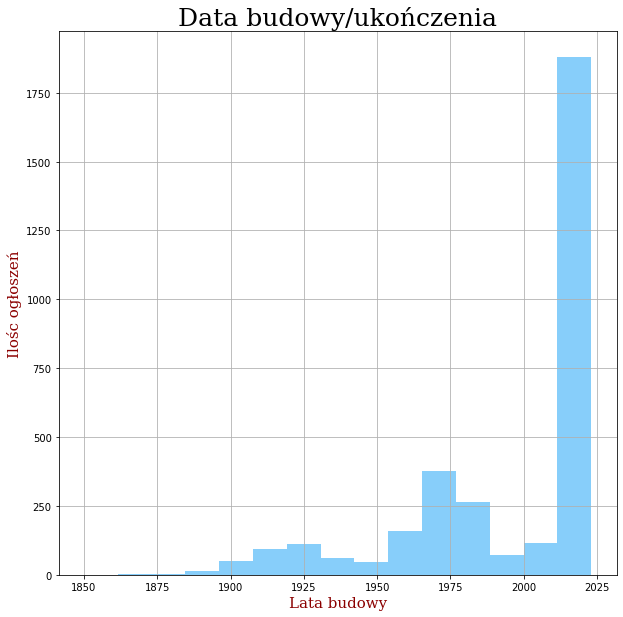

In [20]:
df[df["characteristic_build_year"]>=1850]["characteristic_build_year"]\
    .hist(bins=15, color='lightskyblue', figsize=(10,10))
plt.title('Data budowy/ukończenia', fontdict=font1)
plt.xlabel('Lata budowy', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

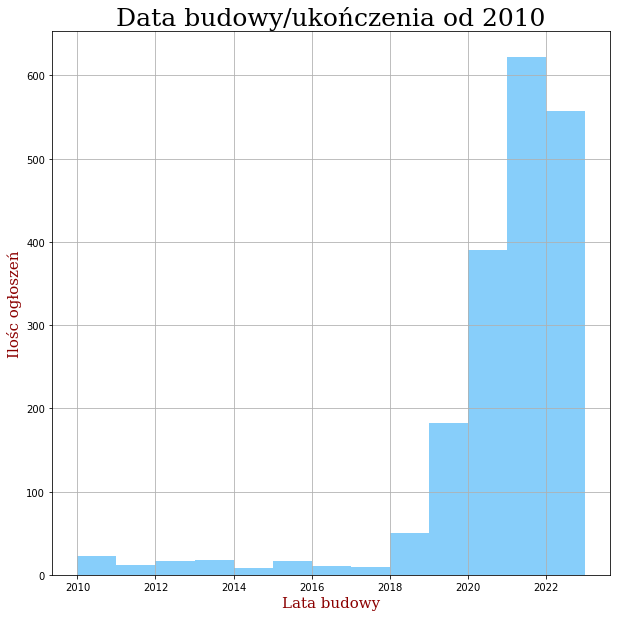

In [21]:
df[df["characteristic_build_year"]>=2010]["characteristic_build_year"]\
    .hist(bins=13, color='lightskyblue', figsize=(10,10))
plt.title('Data budowy/ukończenia od 2010', fontdict=font1)
plt.xlabel('Lata budowy', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

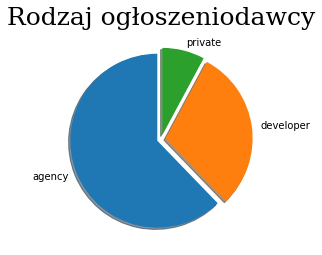

In [22]:
df.groupby("owner_type").size().plot(kind='pie', startangle = 90, explode = [0.05, 0.05, 0.05], shadow = True)
plt.title('Rodzaj ogłoszeniodawcy', fontdict=font1)
plt.ylabel("")
plt.show()

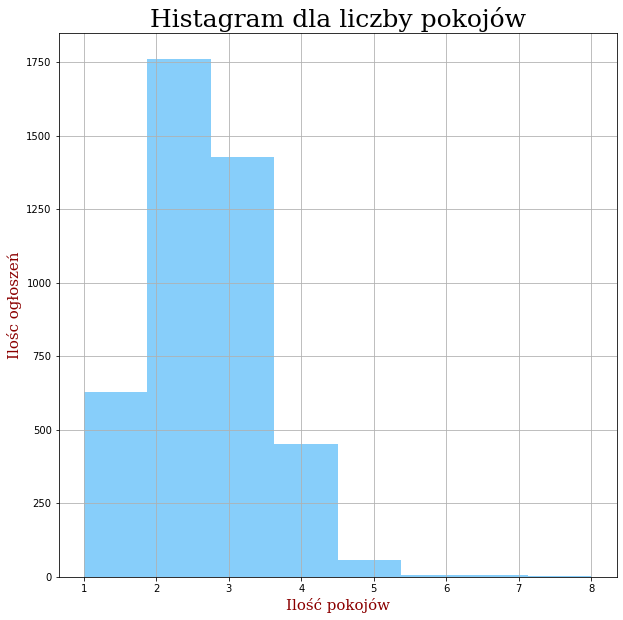

In [23]:
df["characteristic_rooms_num"].plot(kind='hist', bins=8, grid=True, color='lightskyblue', figsize=(10,10))
# display(df["characteristic_rooms_num"].value_counts().sort_values())
plt.title('Histagram dla liczby pokojów', fontdict=font1)
plt.xlabel('Ilość pokojów', fontdict=font2)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.show()

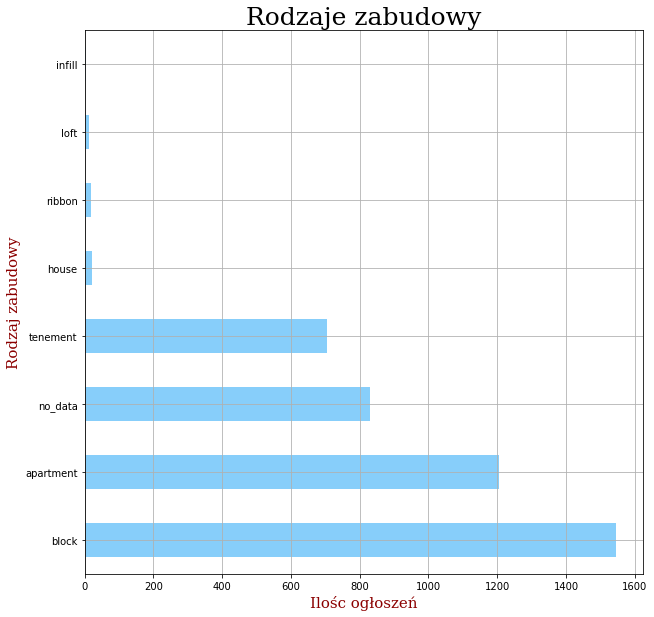

In [24]:
def change_data(d):
    if len(d) == 0:
        return d.strip().replace('', 'no_data')
    else:
        return d

df['characteristic_building_type'] = df['characteristic_building_type'].apply(change_data)
df["characteristic_building_type"].value_counts().plot(kind='barh', grid=True, color='lightskyblue', figsize=(10,10))
plt.title('Rodzaje zabudowy', fontdict=font1)
plt.xlabel('Ilośc ogłoszeń', fontdict=font2)
plt.ylabel('Rodzaj zabudowy', fontdict=font2)
plt.show()

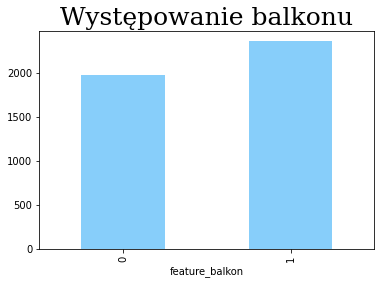

In [25]:
df.groupby("feature_balkon")['ID'].size().plot(kind='bar',color='lightskyblue')
plt.title('Występowanie balkonu', fontdict=font1)
plt.show()

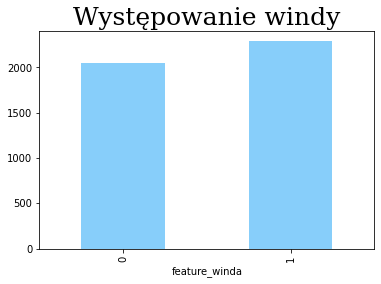

In [26]:
df.groupby("feature_winda").size().plot(kind='bar',color='lightskyblue')
plt.title('Występowanie windy', fontdict=font1)
plt.show()

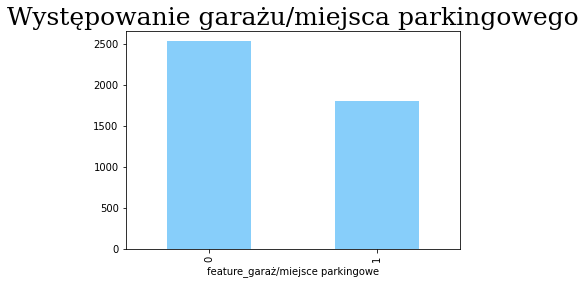

In [27]:
df.groupby("feature_garaż/miejsce parkingowe").size().plot(kind='bar',color='lightskyblue')
plt.title('Występowanie garażu/miejsca parkingowego', fontdict=font1)
plt.show()

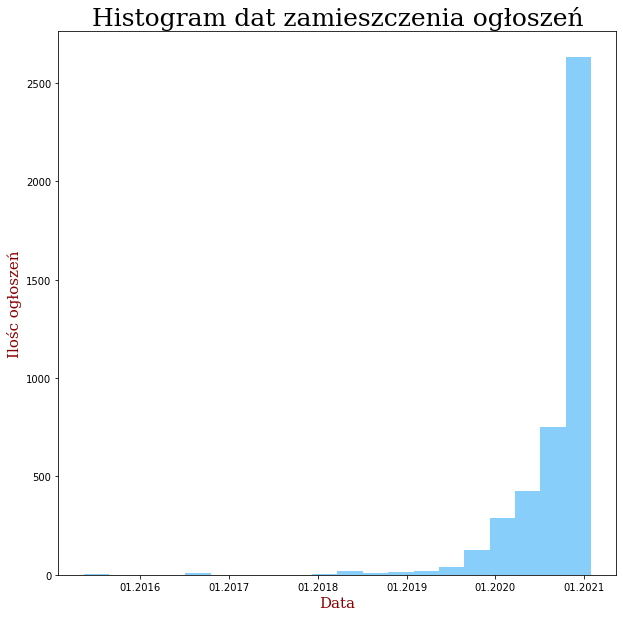

In [28]:
df['offer_dateCreated'] = pd.to_datetime(df['offer_dateCreated'])

fig, ax = plt.subplots(figsize=(10,10))
ax.hist(df["offer_dateCreated"], bins=20, color='lightskyblue')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
plt.title('Histogram dat zamieszczenia ogłoszeń', fontdict=font1)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.xlabel('Data', fontdict=font2)
plt.show()

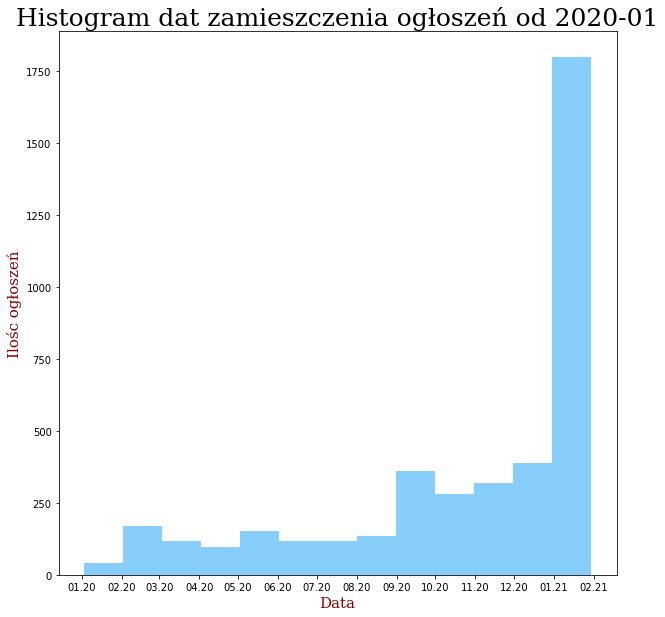

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(df[df["offer_dateCreated"] >= "2020-01"]["offer_dateCreated"], bins=13, color='lightskyblue')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))
plt.title('Histogram dat zamieszczenia ogłoszeń od 2020-01', fontdict=font1)
plt.ylabel('Ilośc ogłoszeń', fontdict=font2)
plt.xlabel('Data', fontdict=font2)
plt.show()